# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [1]:
%matplotlib inline

from time import time
import sys, os
import warnings
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [4]:
DATA_DIR = Path('..', 'data')

In [5]:
prices = (pd.read_hdf(DATA_DIR / 'stooq/daily.h5', 'jp/tse/stocks/prices')
          .loc[idx[:, '2014': '2019'], :])

In [6]:
prices.info(null_counts=True)    

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4848870 entries, (1301.JP, 2014-01-06 00:00:00) to (9997.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      4848870 non-null float64
high      4848870 non-null float64
low       4848870 non-null float64
close     4848870 non-null float64
volume    4848870 non-null int64
dtypes: float64(4), int64(1)
memory usage: 203.5+ MB


In [10]:
before = len(prices.index.get_level_values('symbol').unique())

### Remove symbols with missing values

In [11]:
prices = (prices.unstack('symbol')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('symbol')
        .swaplevel())
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4198624 entries, (1301.JP, 2014-01-06 00:00:00) to (9997.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      4198624 non-null float64
high      4198624 non-null float64
low       4198624 non-null float64
close     4198624 non-null float64
volume    4198624 non-null float64
dtypes: float64(5)
memory usage: 176.2+ MB


In [12]:
after = len(prices.index.get_level_values('symbol').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,706 after: 2,864


### Keep most traded symbols

In [13]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('symbol').median().nlargest(1000).index.tolist()

In [14]:
prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1466000 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      1466000 non-null float64
high      1466000 non-null float64
low       1466000 non-null float64
close     1466000 non-null float64
volume    1466000 non-null float64
dtypes: float64(5)
memory usage: 61.6+ MB


## Feature Engineering

### Compute period returns

In [15]:
intervals = [1, 5, 10, 21, 63]

In [16]:
returns = []
by_sym = prices.groupby(level='symbol').close
for t in intervals:
    returns.append(by_sym.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

In [17]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1466000 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
ret_1     1465000 non-null float64
ret_5     1461000 non-null float64
ret_10    1456000 non-null float64
ret_21    1445000 non-null float64
ret_63    1403000 non-null float64
dtypes: float64(5)
memory usage: 61.6+ MB


### Remove outliers

In [18]:
max_ret_by_sym = returns.groupby(level='symbol').max()

In [19]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.145681,0.268016,0.342887,0.453197,0.699203
std,0.061561,0.209205,0.314211,0.545314,0.822495
min,0.057599,0.081609,0.113061,0.146788,0.192217
50%,0.128268,0.206363,0.254089,0.332171,0.493913
90%,0.226131,0.444332,0.537989,0.675574,1.047346
95%,0.264922,0.659088,0.818955,0.997903,1.697734
97.5%,0.299717,0.875280,1.246553,1.608270,2.842420
99%,0.352163,1.261150,1.984029,2.520177,4.736208
99.5%,0.388679,1.439047,2.400568,3.625636,5.720549


In [20]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 

In [21]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

60

In [22]:
prices = prices.drop(to_drop, level='symbol')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1378040 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 5 columns):
open      1378040 non-null float64
high      1378040 non-null float64
low       1378040 non-null float64
close     1378040 non-null float64
volume    1378040 non-null float64
dtypes: float64(5)
memory usage: 57.9+ MB


### Calculate relative return percentiles

In [23]:
returns = []
by_sym = prices.groupby(level='symbol').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

### Technical Indicators

#### Percentage Price Oscillator

In [24]:
ppo = prices.groupby(level='symbol').close.apply(talib.PPO).to_frame('PPO')

#### Normalized Average True Range

In [25]:
natr = prices.groupby(level='symbol', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator

In [26]:
rsi = prices.groupby(level='symbol').close.apply(talib.RSI).to_frame('RSI')

#### Bollinger Bands

In [27]:
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [28]:
bbands = prices.groupby(level='symbol').close.apply(get_bollinger)

### Combine Features

In [29]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

In [30]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [31]:
data.bbu.corr(data.bbl, method='spearman')

-0.17170294049252643

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1378040 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 20 columns):
open               1378040 non-null float64
high               1378040 non-null float64
low                1378040 non-null float64
close              1378040 non-null float64
volume             1378040 non-null float64
ret_1              1377100 non-null float64
ret_rel_perc_1     1377100 non-null float64
ret_5              1373340 non-null float64
ret_rel_perc_5     1373340 non-null float64
ret_10             1368640 non-null float64
ret_rel_perc_10    1368640 non-null float64
ret_21             1358300 non-null float64
ret_rel_perc_21    1358300 non-null float64
ret_63             1318820 non-null float64
ret_rel_perc_63    1318820 non-null float64
PPO                1354540 non-null float64
NATR               1364880 non-null float64
RSI                1364880 non-null float64
bbl                1374280 non-null float64

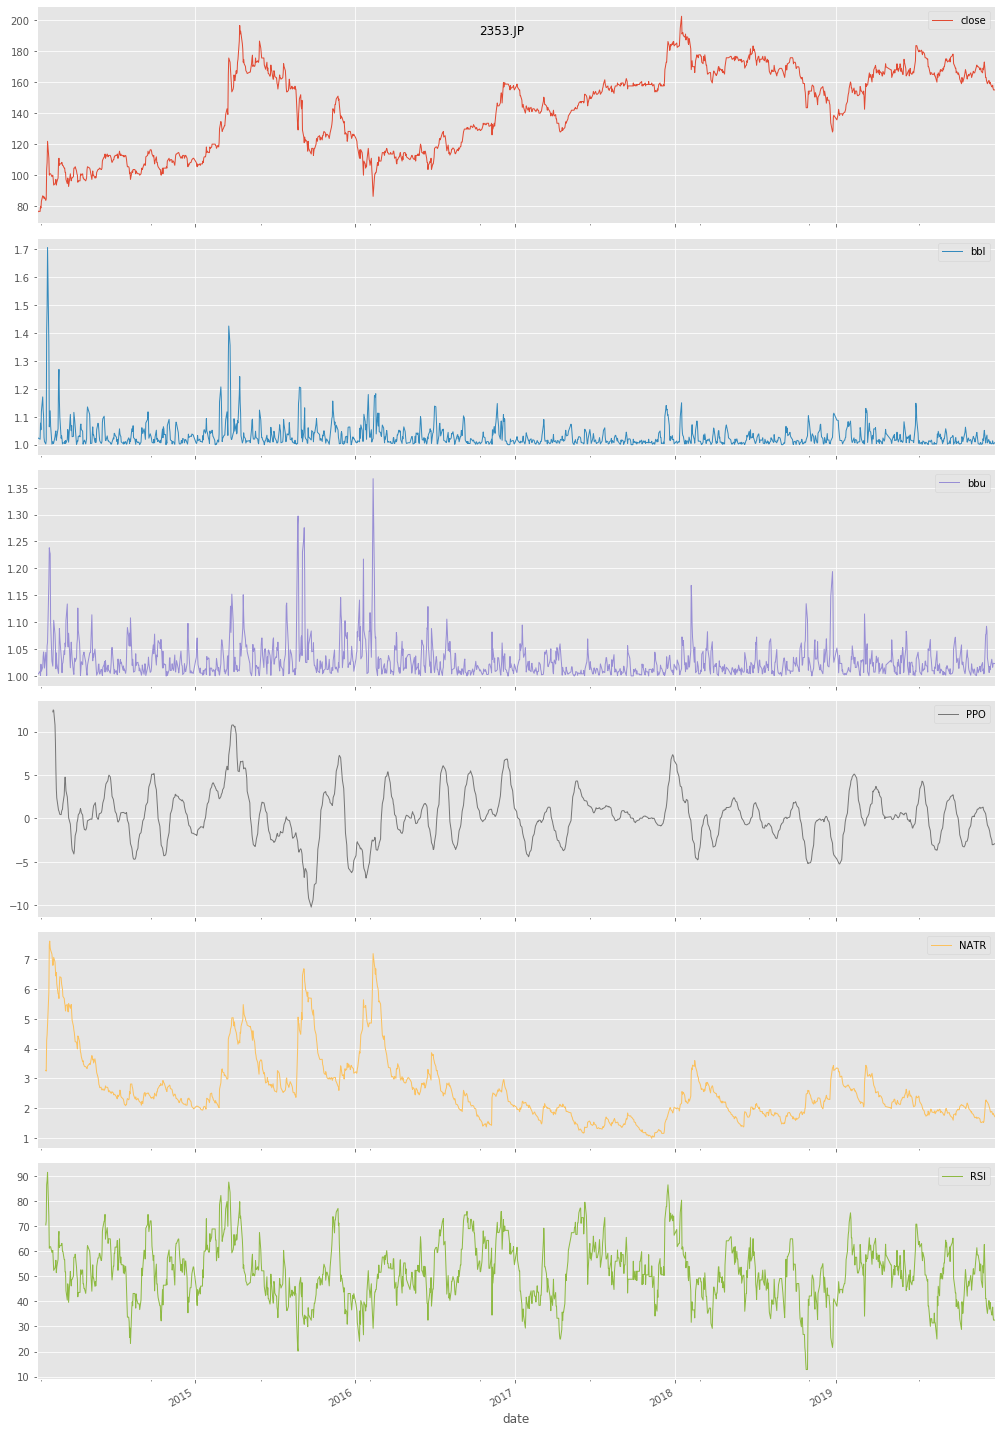

In [33]:
ticker = np.random.choice(data.index.get_level_values('symbol'))
(data.loc[idx[ticker, :], ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']].reset_index('symbol', drop=True)
 .plot(lw=1, subplots=True, figsize=(14, 20), title=ticker))
plt.tight_layout();

In [34]:
data = data.drop(prices.columns, axis=1)

In [35]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [36]:
with pd.HDFStore('data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/preds_lgb                       frame        (shape->[532040,4])  
/quandl/us/equities              frame        (shape->[171162,61]) 
/stooq/japan/equities            frame        (shape->[1378040,23])


In [37]:
outcomes = []
by_symbol = data.groupby('symbol')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_symbol[f'ret_{t}'].shift(-t)

In [38]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1378040 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 23 columns):
ret_1              1377100 non-null float64
ret_rel_perc_1     1377100 non-null float64
ret_5              1373340 non-null float64
ret_rel_perc_5     1373340 non-null float64
ret_10             1368640 non-null float64
ret_rel_perc_10    1368640 non-null float64
ret_21             1358300 non-null float64
ret_rel_perc_21    1358300 non-null float64
ret_63             1318820 non-null float64
ret_rel_perc_63    1318820 non-null float64
PPO                1354540 non-null float64
NATR               1364880 non-null float64
RSI                1364880 non-null float64
bbl                1374280 non-null float64
bbu                1374280 non-null float64
weekday            1378040 non-null int64
month              1378040 non-null int64
year               1378040 non-null int64
fwd_ret_01         1377100 non-null float64
fwd_r

In [39]:
data.to_hdf('data.h5', 'stooq/japan/equities')